Tarea 2: Perceptrón y MSV 
----

Román Alberto Vélez Jiménez, CU: 165462  

Naomi Zuleth Cabrera Andrade, CU: 165398 

Jesús Eduardo Torres Ruiz, CU: 166079


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from urllib.request import urlretrieve
from random import randrange

# own functions
from svm_gradiente import svm_gradient
from svm_gds import svm_sgd
from svm_gds import loss_01
from Perceptron import perceptron

## Toy data
Para ver que correctamente se están ejecutando los métodos, antes de probarlos con el iris set data, los probaremos con datos simulados que sabemos que son linealmente separables

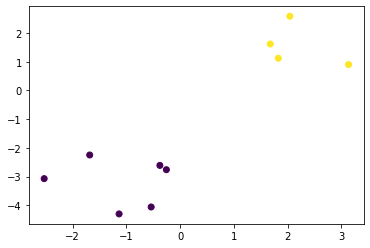

In [2]:
#toy data set
np.random.seed(1)
x_test = np.random.randn(6,2) - 2
x_test = np.vstack((x_test, np.random.randn(4,2) + 2))
y_test = np.array([-1 if x < 6 else 1 for x in range(10)])

#hyper paramethers
lambd_test = 1
rho_test = 0.1
tol_test = 1e-3
max_iter = 100

# # look linear separable data
x = x_test[:,0]
y = x_test[:,1]
t = np.linspace(x.min(), x.max())

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, c=y_test)
plt.show()


Perceptron
---

Veamos con el toy data que el perceptron está funcionando correctamente


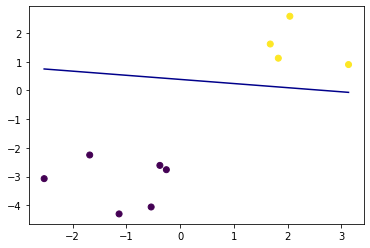

In [3]:
# test con perceptron
th1, th0, tries = perceptron(x_test, y_test)


t = np.linspace(x.min(), x.max())
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, c=y_test)
ax.plot(t, -(th1[tries][0] * t + th0[tries]) / th1[tries][1], color='darkblue')

plt.show()

SVM
---

Veamos con el toy data que el svm está funcionando correctamente


Reached optimum at k = 5


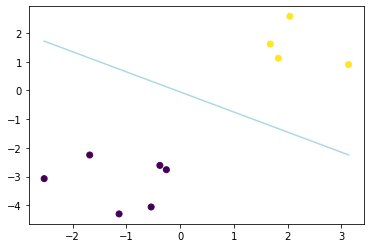

In [4]:
# test SVM Gradient (is ok)
th_ans, th0_ans, k_ans = svm_gradient(x_test, y_test, rho_test, lambd_test, tol_test, max_iter)

# # look data and SVM
t = np.linspace(x.min(), x.max())

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, c=y_test)
ax.plot(t, -(th_ans[k_ans][0] * t + th0_ans[k_ans]) / th_ans[k_ans][1], color='lightblue')
plt.show()


SVM estocástico
---

Veamos con el toy data que el svm estocástico está funcionando correctamente. Pondremos una semilla para que el índice estocástico sea siempre el mismo.

Reached optimum at k = 29


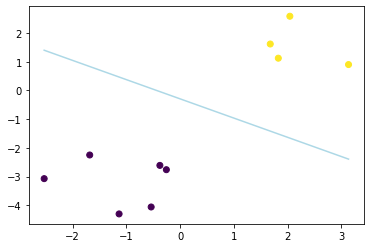

In [5]:
# test SVM Stochastic Gradient (is ok)
th_ans, th0_ans, k_ans = svm_sgd(x_test, y_test, rho_test, lambd_test, tol_test, max_iter)

# # look data and SVM
t = np.linspace(x.min(), x.max())

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y, c=y_test)
ax.plot(t, -(th_ans[k_ans][0] * t + th0_ans[k_ans]) / th_ans[k_ans][1], color='lightblue')
plt.show()


# Datos iris

In [6]:
iris = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
urlretrieve(iris)
df = pd.read_csv(iris, sep=',')
columnas = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
df.columns = columnas
y=df["class"]
y=DataFrame([1 if i=="Iris-setosa" else -1 for i in y], columns=['class'])
df["class"]=y

In [16]:
def split_data(df, k):
    dataset_split = []
    aux = df.values.tolist()
    fold_size = int(len(df)/k)
    for i in range (k): 
        fold=[]
        while len(fold)<fold_size : 
            index = randrange(len(aux))
            fold.append(aux.pop(index))            
        dataset_split.append(fold)
    return dataset_split                  

In [8]:
def test_train(split_data, i):   
    test = []
    aux = list(split_data)    
    test.append(aux.pop(i))
    train = np.array(aux[0])
    j = 1
    while j<len(aux): 
        a = np.array(aux[j])
        train= np.vstack((a,train)) 
        j=j+1
    test=np.array(test[0])
    return (test,train)

In [9]:
def cross_validation(split_data, attributes, rho, l, tol_test, max_iter):    
    kfold_error = []   
    k=len(split_data)
    for i in range (k):
        #split data into test and train
        test, train = test_train(split_data, i)
        test = DataFrame (test,columns = attributes)    
        train= DataFrame (test,columns = attributes) 
        
        #split data into dependent and independent variables
        x_test = np.asarray(test.filter(attributes[0:len(attributes)-1], axis = 1))
        y_test = np.asarray(test[attributes[-1]]) 
        x_train = np.asarray(train.filter(attributes[0:len(attributes)-1], axis = 1))
        y_train = np.asarray(train[attributes[-1]]) 
        
        #training
        th, th0, k_ans = svm_gradient(x_train, y_train, rho, l, tol_test, max_iter)       
        
        #test_error
        th = th[-1]
        th0 = th0[-1]
        n = len(x_test)
        test_error = 0
        for j in range (n):
            test_error = test_error + abs(loss_01(th, th0, x_test[j], y_test[j]))    
        kfold_error.append(test_error/n)
        
        
    kfold_error=sum(kfold_error)/k
        
    return kfold_error 
        

In [30]:
def lambda_optima(df, k, attributes, rho, lambdas, tol_test, max_iter):
    split = split_data(df, k)
    lamb_error = []    
    for l in lambdas: 
        lamb_error.append(cross_validation(split, attributes, rho, l, tol_test, max_iter)) 
    minimo = lambdas[lamb_error.index(min(lamb_error))]
    
    #plot lambdas error
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(np.array(lambdas), np.array(lamb_error), '-r')
    ax.set(title='Lambdas hiperparameter SVM',
          ylabel = 'Cross Validation Error',
          xlabel = 'lambda')
    plt.show()

    
    return(minimo, min(lamb_error))     



# Prueba
Para clasificar usaremos 2 algoritmos: el Perceptrón y Descenso por gradiente MVS.

## Perceptron 
Utilizando las ultimas dos columnas del dataset iris, "sepal_length" y "sepal_width". Esto para que sea posible graficar

### Validación Cruzada

In [11]:
only_two_variables = df.loc[:,[True, True, False, False, True]]
datasplit=split_data(only_two_variables,5) # se divide en 5 

Las graficas mostradas son las de prueba es decir contienen el 20% de datos con el que se prueba e exito del modelo. 

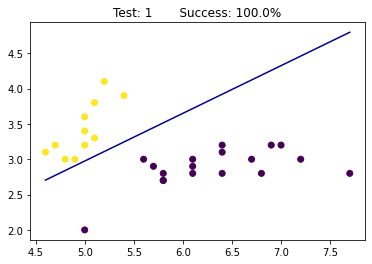

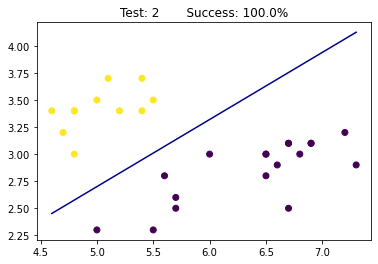

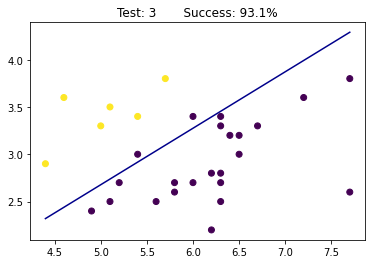

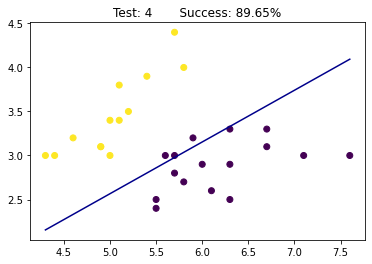

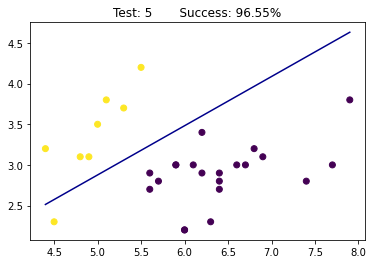

In [37]:
# set seed to get always same values
np.random.seed(1)

# test data
for i in range(5):
    testdata=test_train(datasplit, i)
    x_training = testdata[1][:,0:2]
    y_training = testdata[1][:,2]
    th1, th0, tries = perceptron(x_training, y_training)
    
    #Verificacion
    x_prueba = testdata[0][:,0:2]
    y_prueba = testdata[0][:,2]
    
    success = 0
    for k in range(len(y_prueba)):
        signo=(np.dot(x_prueba[k], th1[tries])+th0[tries])*y_prueba[k]
        if signo > 0:
            success += 1
    
    #truncar a solo 2 decimales
    success=success/len(y_prueba)
    success = int(success*10000)/100
    
    #Para graficar
    x = x_prueba[:,0]
    y = x_prueba[:,1]
    t = np.linspace(x.min(), x.max())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(x, y, c=y_prueba)
    ax.set_title("Test: " + str(i+1) + "       Success: " + str(success) + "%")
    ax.plot(t, -(th1[tries][0] * t + th0[tries]) / th1[tries][1], color='darkblue')
    plt.show()


    

### Descenso por gradiente MVS
Primero, obtendremos la lambda óptima usando el algoritmo de Descenso por gradiente MVS. Para esto, se correrán varios experimentos con validación cruzada. 

Reached optimum at k = 5
Reached optimum at k = 99
Reached optimum at k = 4
Reached optimum at k = 89
Reached optimum at k = 8
Reached optimum at k = 16
Reached optimum at k = 9
Couldn't reach optimum
Reached optimum at k = 99
Reached optimum at k = 30
Reached optimum at k = 19
Reached optimum at k = 8
Reached optimum at k = 5
Couldn't reach optimum
Reached optimum at k = 12
Reached optimum at k = 11
Reached optimum at k = 25
Reached optimum at k = 4
Couldn't reach optimum
Reached optimum at k = 5
Reached optimum at k = 5
Reached optimum at k = 10
Reached optimum at k = 3
Couldn't reach optimum
Reached optimum at k = 25
Reached optimum at k = 4
Reached optimum at k = 3
Reached optimum at k = 4
Couldn't reach optimum
Reached optimum at k = 9
Reached optimum at k = 5
Reached optimum at k = 10
Reached optimum at k = 5
Couldn't reach optimum
Reached optimum at k = 23
Reached optimum at k = 9
Reached optimum at k = 4
Reached optimum at k = 19
Couldn't reach optimum
Reached optimum at k = 63

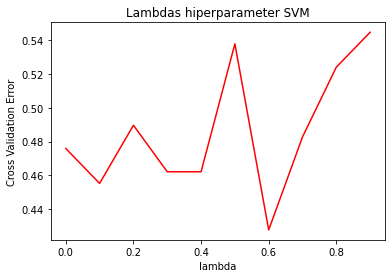

In [34]:
#set seed
np.random.seed(1)

# init
lambdas= list(np.arange(10)/10)
k=5
rho_test = 0.1
tol_test = 1e-3
max_iter = 100
attributes=["petal_length", "petal_width", "class"]
df=df.filter(attributes, axis=1)

# get lambda
lambda_opt, error_lambda=lambda_optima(df, k, attributes, rho_test, lambdas, tol_test, max_iter)

In [38]:
print("La lambda óptima es de:", lambda_opt)
print("\nEl error de la validación cruzada a dicha lambda es de: ", error_lambda)

La lambda óptima es de: 0.6

El error de la validación cruzada a dicha lambda es de:  0.4275862068965517


Observamos que la lambda $\lambda$ óptima es la anterior y su error asociado es el anterior, por lo que haremos el test con este hiperparámetro.

Concluímos por tanto que el mejor algoritmo de clasificación es el de